In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os
from skimage.io import imread
import numpy as np

In [2]:
all_images = glob(os.path.join('..', 'data', '*.tif'))
img_df = pd.DataFrame([dict(path = c_file) for c_file in all_images])
img_df['basename'] = img_df['path'].map(lambda x: os.path.basename(x).split('.')[0])
img_df['frame_id'] = img_df['basename'].map(lambda x: '_'.join(x.split('_')[0:-1]))
img_df['sample'] = img_df['basename'].map(lambda x: x.split('_')[0])
img_df['slice'] = img_df['basename'].map(lambda x: int(x.split('_')[3]))
img_df['frame'] = img_df['basename'].map(lambda x: int(x.split('_')[1]))
img_df.sample(10)

,path,basename,frame_id,sample,slice,frame
20,../data/MI5_0_00_1503.rec.8bit.tif,MI5_0_00_1503,MI5_0_00,MI5,1503,0
63,../data/MI5_1_01_1510.rec.8bit.tif,MI5_1_01_1510,MI5_1_01,MI5,1510,1
37,../data/MI7_1_00_1308.rec.8bit.tif,MI7_1_00_1308,MI7_1_00,MI7,1308,1
48,../data/MI7_0_00_1305.rec.8bit.tif,MI7_0_00_1305,MI7_0_00,MI7,1305,0
51,../data/MI7_0_00_1310.rec.8bit.tif,MI7_0_00_1310,MI7_0_00,MI7,1310,0
83,../data/MI7_1_02_1306.rec.8bit.tif,MI7_1_02_1306,MI7_1_02,MI7,1306,1
49,../data/MI7_0_00_1302.rec.8bit.tif,MI7_0_00_1302,MI7_0_00,MI7,1302,0
96,../data/MI5_1_02_1500.rec.8bit.tif,MI5_1_02_1500,MI5_1_02,MI5,1500,1
93,../data/MI5_0_00_1507.rec.8bit.tif,MI5_0_00_1507,MI5_0_00,MI5,1507,0
28,../data/MI7_1_00_1310.rec.8bit.tif,MI7_1_00_1310,MI7_1_00,MI7,1310,1


# Show Images and Histogram for Samples
Here we show the images and the histograms for the samples

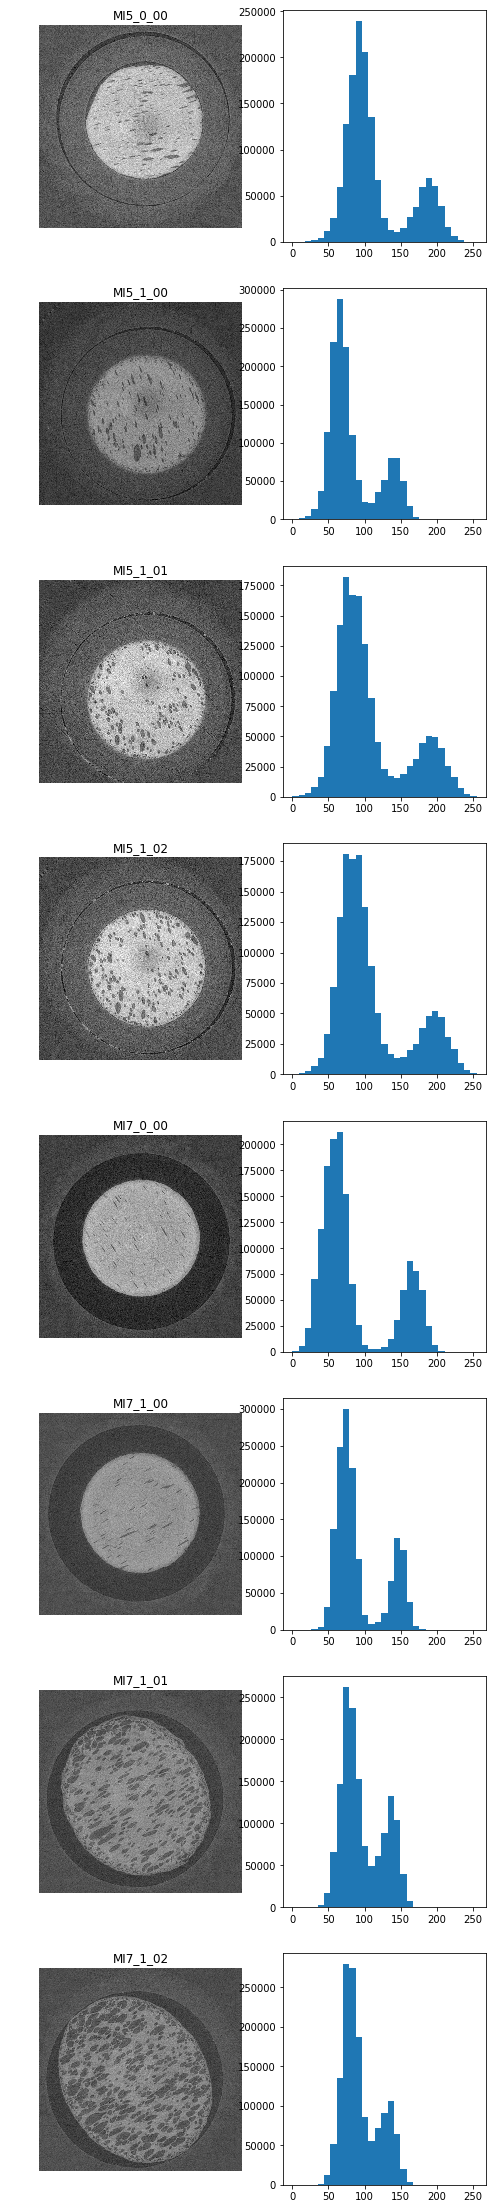

In [3]:
frames_iter = img_df.sort_values(['sample', 'frame', 'slice']).groupby(['frame_id'])
fig, m_axs = plt.subplots(len(frames_iter), 2, figsize = (8, 5*len(frames_iter)))
for (c_ax_img, c_ax_hist), (c_name, c_df) in zip(m_axs, frames_iter):
    c_slice = imread(c_df['path'].values[0])
    c_ax_img.imshow(c_slice, cmap = 'gray', vmin = 0, vmax = 255)
    c_ax_img.set_title(c_name)
    c_ax_img.axis('off')
    c_ax_hist.hist(c_slice.ravel(), np.linspace(0, 255, 30))

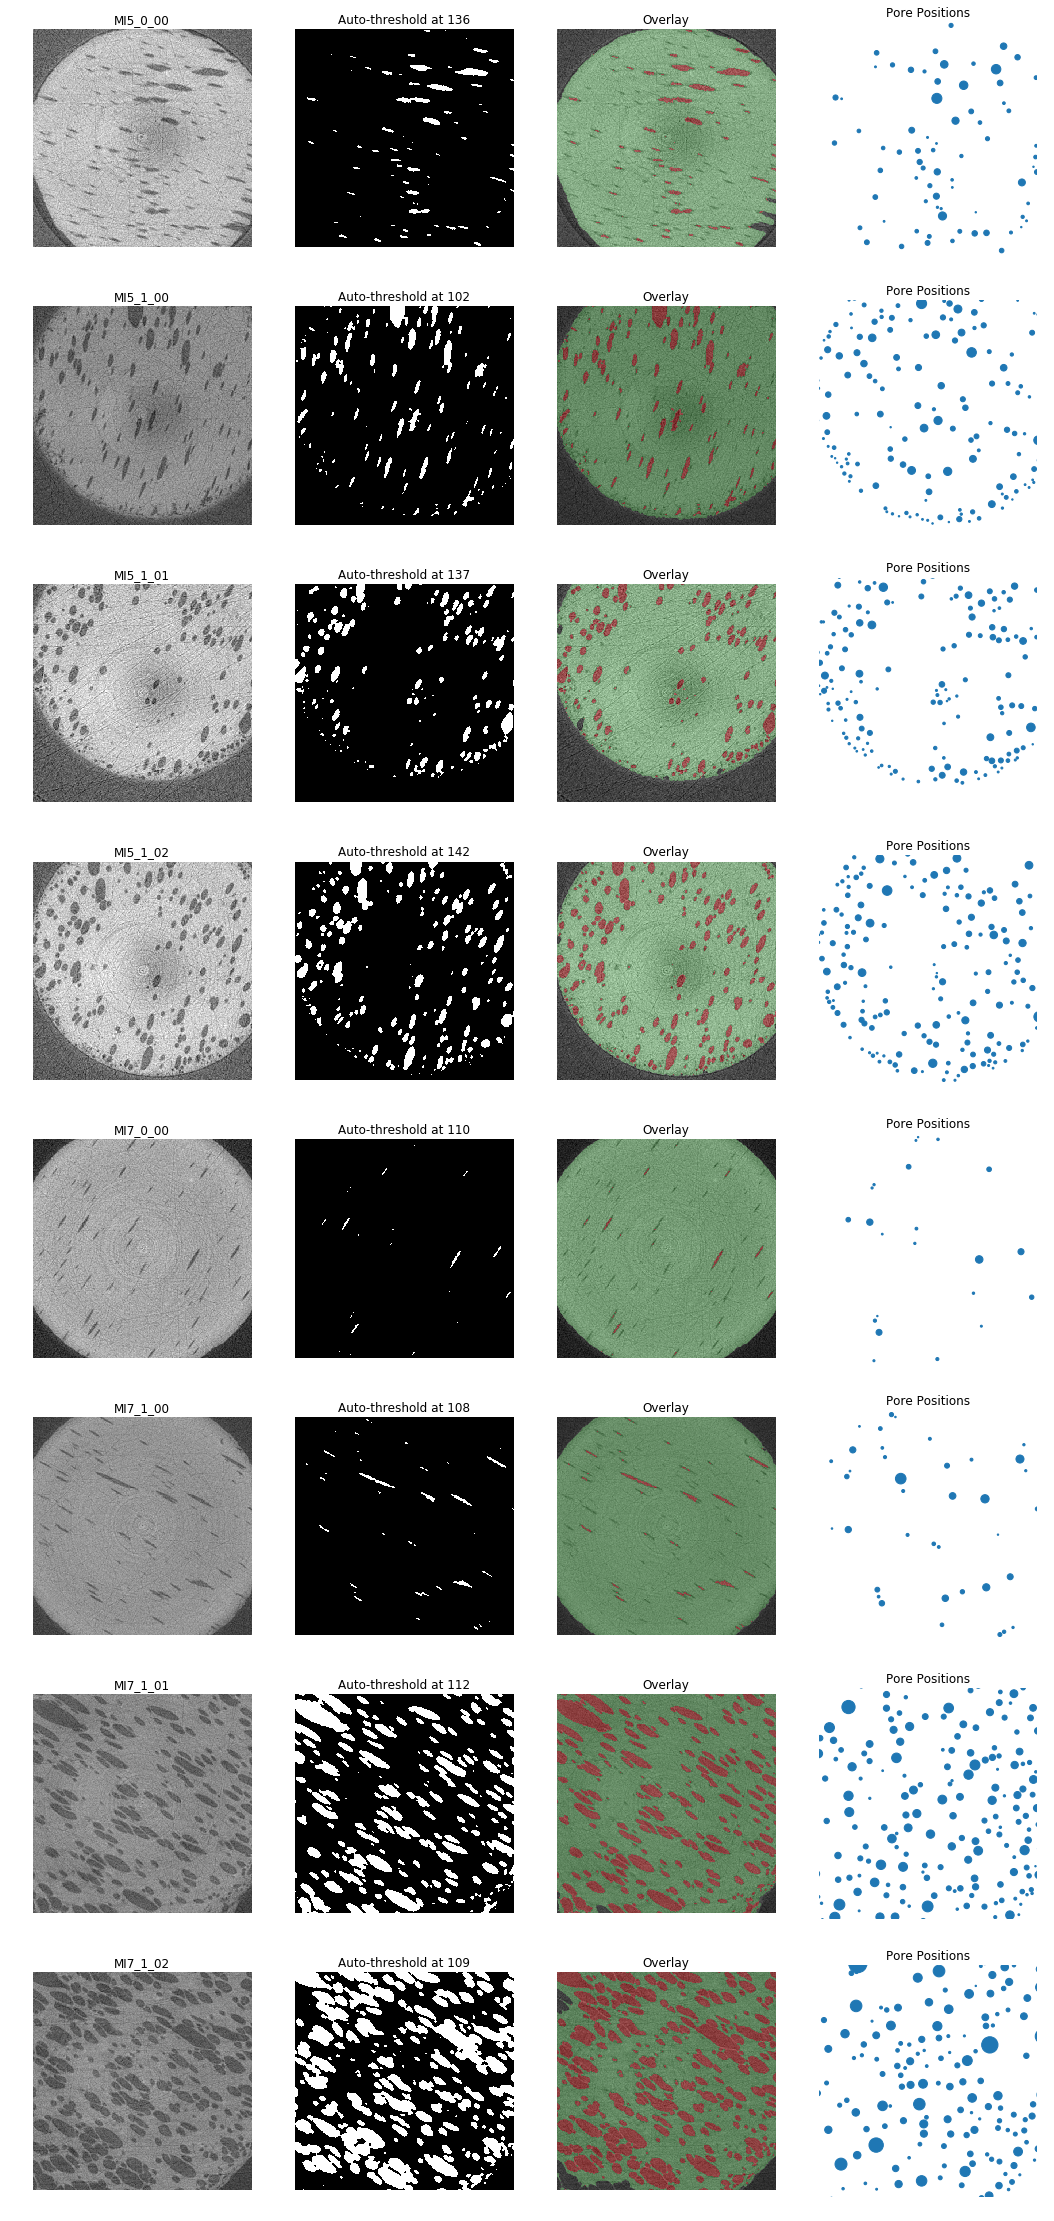

In [4]:
from skimage.filters import threshold_minimum
from skimage.morphology.convex_hull import convex_hull_image
from skimage.morphology import binary_closing, binary_opening, disk, label
from skimage.measure import regionprops

from skimage.color import label2rgb
from scipy import ndimage as ndi

def threshold_slice_2d(raw_slice):
    in_slice = ndi.median_filter(raw_slice, [7, 7])
    # basic threshold
    thresh_min = threshold_minimum(in_slice)
    # make solid component
    solid_part = binary_closing(in_slice>thresh_min, disk(4))
    solid_part = ndi.binary_fill_holes(solid_part)
    # calculate porous component inside solid
    porous_part = (in_slice < thresh_min)*solid_part
    #porous_part = binary_opening(porous_part, disk(2))
    porous_part = binary_closing(porous_part, disk(2))
    # create label by combining
    label_slice = solid_part.astype(np.uint8).clip(0,1)
    label_slice += (porous_part).astype(np.uint8).clip(0,1)
    return label_slice, thresh_min


fig, m_axs = plt.subplots(len(frames_iter), 4, 
                          figsize = (18, 5*len(frames_iter)))

[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (c_ax_img, c_ax_seg, c_ax_over, c_plot), (c_name, c_df) in zip(m_axs, frames_iter):
    c_slice = imread(c_df['path'].values[0])
    c_ax_img.imshow(c_slice, cmap = 'gray', vmin = 0, vmax = 255)
    c_ax_img.set_title(c_name)
    
    # calculate threshold
    lab_por_img, thresh_min = threshold_slice_2d(c_slice)
    
    c_ax_seg.imshow(lab_por_img==2, cmap = 'bone')
    c_ax_seg.set_title('Auto-threshold at {}'.format(thresh_min))
    
    c_ax_over.imshow(label2rgb(lab_por_img, 
                               image = c_slice, bg_label=0, 
                               colors = ['green', 'red']))
    c_ax_over.set_title('Overlay')

    all_regs = regionprops(label(lab_por_img==2), intensity_image = c_slice)
    c_plot.scatter([x.centroid[1] for x in all_regs], 
                   [x.centroid[0] for x in all_regs],
                  s = [x.major_axis_length for x in all_regs])
    c_plot.set_title('Pore Positions')
    

# only show a smaller ROI
_ = [c_ax.set_xlim(300, c_slice.shape[0]-300) for c_ax in m_axs.flatten()], [c_ax.set_ylim(300, c_slice.shape[1]-300) for c_ax in m_axs.flatten()]

# 2D Analysis
Here we do a 2D analysis slice by slice

In [5]:
from tqdm import tqdm
all_pores = []
for _, c_row in tqdm(list(img_df.iterrows())):
    c_dict = c_row.to_dict()
    c_slice = imread(c_row['path'])
    lab_por_img, thresh_min = threshold_slice_2d(c_slice)
    c_dict['solid_volume_fraction'] = np.sum(lab_por_img==1)/np.sum(lab_por_img>0)
    c_dict['porous_volume_fraction'] = np.sum(lab_por_img==2)/np.sum(lab_por_img>0)
    all_regs = regionprops(label(lab_por_img==2), intensity_image = c_slice)
    for c_reg in all_regs:
        c_pore = c_dict.copy()
        for c_key in ['major_axis_length', 'minor_axis_length', 'area', 'centroid', 'orientation', 'mean_intensity', 'perimeter']:
            c_pore[c_key] = getattr(c_reg, c_key)
        
        all_pores += [c_pore]
poros_df = pd.DataFrame(all_pores)
poros_df.to_csv('porosity_analyis.csv')
poros_df.sample(10)

100%|██████████| 104/104 [02:06<00:00,  1.21s/it]


,area,basename,centroid,frame,frame_id,major_axis_length,mean_intensity,minor_axis_length,orientation,path,perimeter,sample,slice
7062,5,MI7_1_01_1304,"(757.8, 179.8)",1,MI7_1_01,6.449806,99.200000,1.385641,0.785398,../data/MI7_1_01_1304.rec.8bit.tif,3.828427,MI7,1304
5988,67,MI7_1_01_1311,"(408.2238805970149, 897.3731343283582)",1,MI7_1_01,12.730112,96.253731,6.783738,-0.630613,../data/MI7_1_01_1311.rec.8bit.tif,31.213203,MI7,1311
25872,8,MI7_1_01_1300,"(815.875, 984.375)",1,MI7_1_01,6.147837,112.750000,1.924605,1.534098,../data/MI7_1_01_1300.rec.8bit.tif,8.207107,MI7,1300
22811,30,MI7_1_01_1301,"(296.43333333333334, 311.6333333333333)",1,MI7_1_01,8.100008,105.666667,5.810994,-0.029607,../data/MI7_1_01_1301.rec.8bit.tif,19.692388,MI7,1301
21862,21,MI7_1_02_1306,"(572.8095238095239, 965.952380952381)",1,MI7_1_02,6.210701,98.380952,4.746020,1.040485,../data/MI7_1_02_1306.rec.8bit.tif,15.656854,MI7,1306
13555,32,MI5_1_01_1505,"(419.8125, 476.3125)",1,MI5_1_01,8.482083,117.406250,5.092079,-0.353282,../data/MI5_1_01_1505.rec.8bit.tif,21.106602,MI5,1505
12704,1,MI5_1_02_1508,"(903.0, 195.0)",1,MI5_1_02,0.000000,146.000000,0.000000,0.785398,../data/MI5_1_02_1508.rec.8bit.tif,0.000000,MI5,1508
11758,2,MI7_1_02_1303,"(181.0, 419.5)",1,MI7_1_02,2.000000,104.500000,0.000000,-0.000000,../data/MI7_1_02_1303.rec.8bit.tif,0.000000,MI7,1303
17326,70,MI7_1_02_1307,"(744.7428571428571, 994.7142857142857)",1,MI7_1_02,14.647449,89.771429,8.267121,-1.132361,../data/MI7_1_02_1307.rec.8bit.tif,38.627417,MI7,1307
8786,295,MI5_1_02_1509,"(794.1322033898305, 829.0508474576271)",1,MI5_1_02,28.308373,113.650847,13.420820,-1.020993,../data/MI5_1_02_1509.rec.8bit.tif,69.012193,MI5,1509


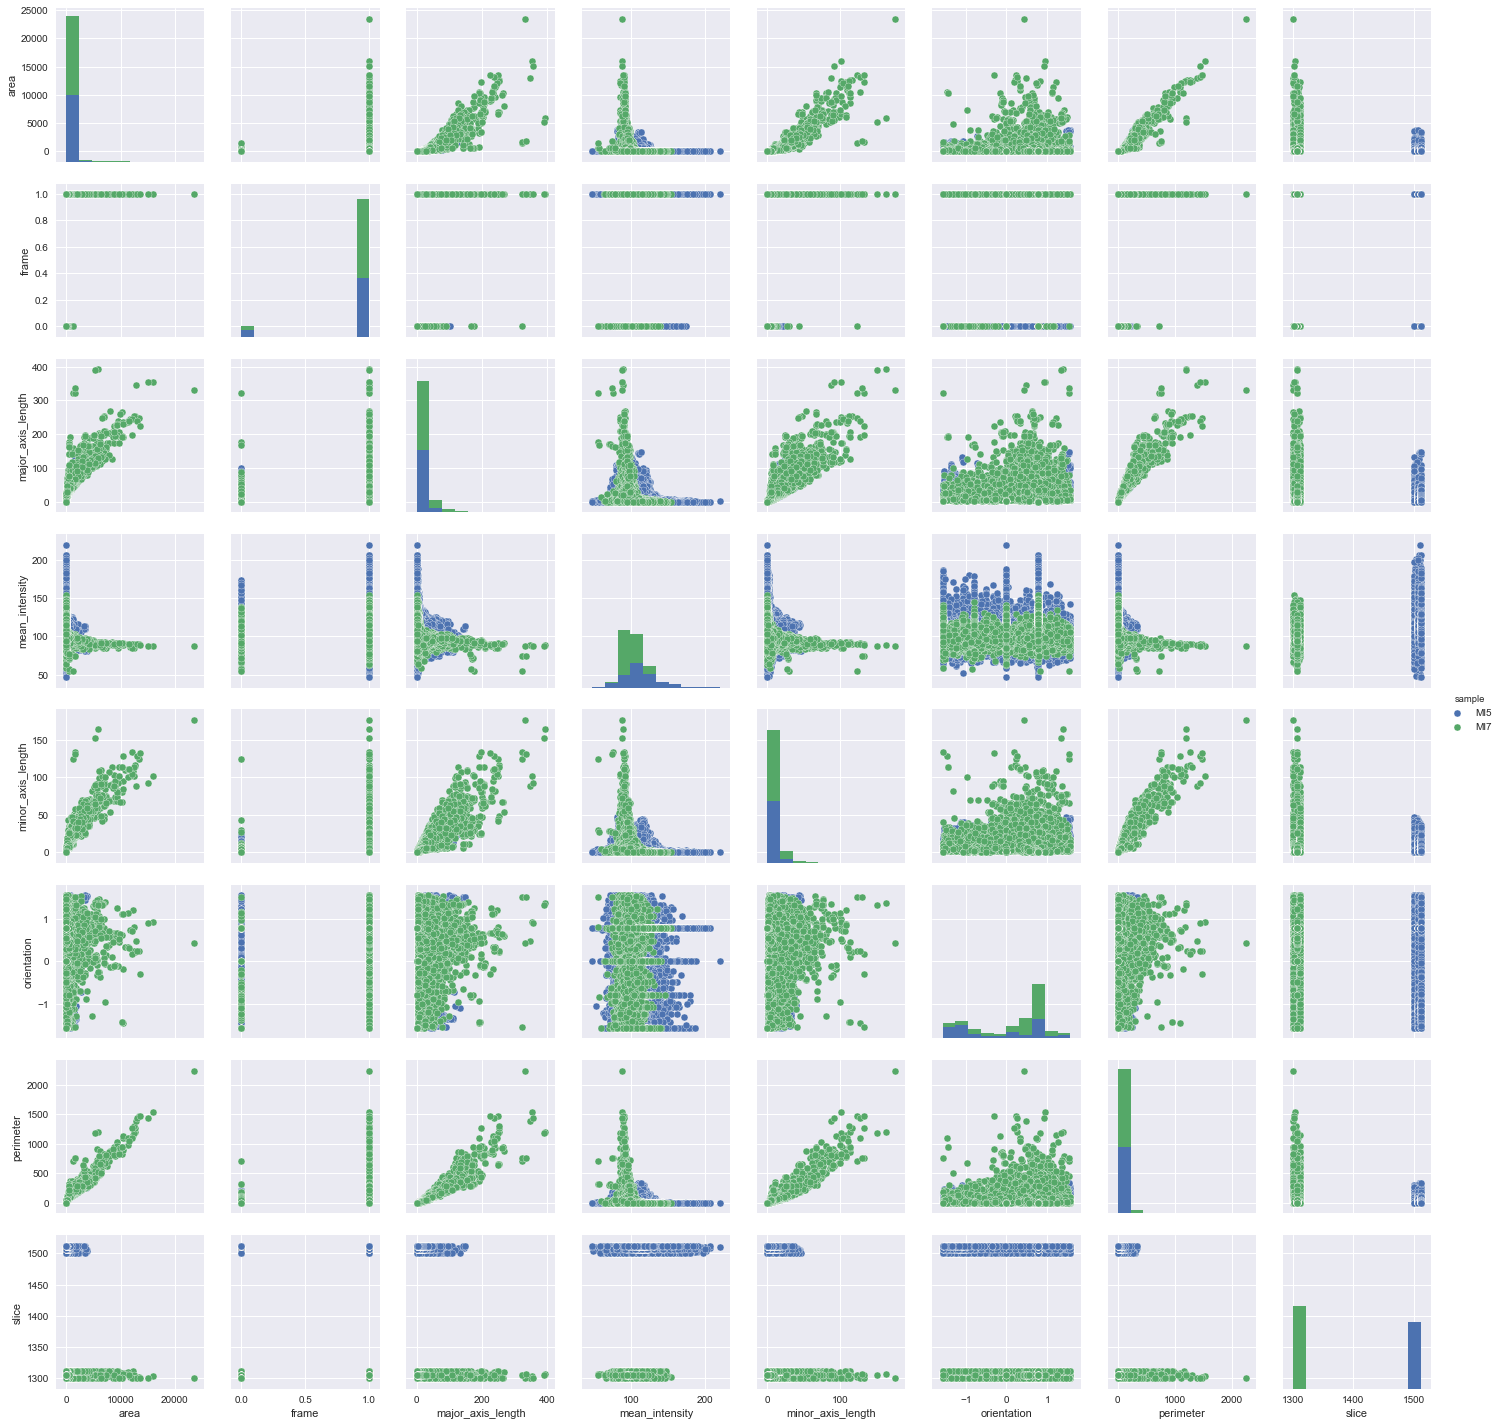

In [6]:
import seaborn as sns
sns.pairplot(poros_df, hue = 'sample')